In [37]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/all_vessel_calls.csv")

In [4]:
df.columns, df.shape

(Index(['arrivalDate', 'sailingDate', 'place.placeName', 'place.unlocode',
        'place.placeType', 'place.countryName', 'Timestamp', 'Event_Type',
        'IMO'],
       dtype='object'),
 (352968, 9))

In [147]:
code_df = pd.read_csv("../data/unlocode-list.csv", usecols=['Country', 'Location', 'Coordinates'])

In [148]:
code_df.columns, code_df.shape

(Index(['Country', 'Location', 'Coordinates'], dtype='object'), (116074, 3))

In [149]:
code_df['place.unlocode'] = code_df['Country'] + code_df['Location']

In [130]:
# display(df)

In [151]:
code_df.drop_duplicates(subset=['place.unlocode'])

,Country,Location,Coordinates,place.unlocode
0,AD,ALV,4230N 00131E,ADALV
1,AD,CAN,4234N 00135E,ADCAN
2,AD,ENC,4232N 00134E,ADENC
3,AD,ESC,4231N 00133E,ADESC
4,AD,EAC,4233N 00131E,ADEAC
...,...,...,...,...
116069,ZW,STH,1751S 03101E,ZWSTH
116070,ZW,THJ,1800S 02626E,ZWTHJ
116071,ZW,VFA,NaN,ZWVFA
116072,ZW,ZMZ,2016S 03055E,ZWZMZ


In [152]:
df.dropna(subset=['place.unlocode'])
code_df.dropna(subset=['place.unlocode'])

,Country,Location,Coordinates,place.unlocode
0,AD,ALV,4230N 00131E,ADALV
1,AD,CAN,4234N 00135E,ADCAN
2,AD,ENC,4232N 00134E,ADENC
3,AD,ESC,4231N 00133E,ADESC
4,AD,EAC,4233N 00131E,ADEAC
...,...,...,...,...
116069,ZW,STH,1751S 03101E,ZWSTH
116070,ZW,THJ,1800S 02626E,ZWTHJ
116071,ZW,VFA,NaN,ZWVFA
116072,ZW,ZMZ,2016S 03055E,ZWZMZ


In [169]:
merged_df = df.merge(code_df, on='place.unlocode')
# merged_df

In [170]:
morning_champ_df = merged_df[merged_df['IMO'] == 9285627]
glovis_sonic_df =  merged_df[merged_df['IMO'] == 9798387]

In [171]:
# visualize morning_champ_df
# convert coordinates
morning_champ_df[morning_champ_df['Coordinates'].isnull()]['place.placeName'].unique(), morning_champ_df[morning_champ_df['Coordinates'].isnull()]['place.unlocode'].unique()

(array([], dtype=object), array([], dtype=object))

In [172]:
# convert coordinates - seperate them into lat and log
morning_champ_df['lat'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[0] if x else None)
morning_champ_df['lon'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[1] if x  else None)
# # convert coordinates - read direction
morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: '-' + x[:-1] if x[-1:] == 'S' else x[:-1])
morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: '-' + x[:-1] if x[-1:] == 'W' else x[:-1])
# morning_champ_df

In [173]:
# convert to float with the last two digits being decimal points
def handle_lat_lon(x):
    if x:
        if '-' in x:
            return float(x[:-2]) + float(x[0] + x[-2:])/100
        else:
            return float(x[:-2]) + float(x[-2:])/100
    return None


morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: handle_lat_lon(x))
morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: handle_lat_lon(x))
# print(morning_champ_df.to_string())

In [229]:
morning_champ_df = morning_champ_df.reset_index(drop=True)
morning_champ_df = morning_champ_df.sort_values(by='Timestamp')

In [232]:
from shapely.geometry import LineString, Point  # Import Point for arrow head (optional)
import matplotlib.pyplot as plt
from matplotlib import patches  # For creating arrow patches
import numpy as np

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_22044\2070837493.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


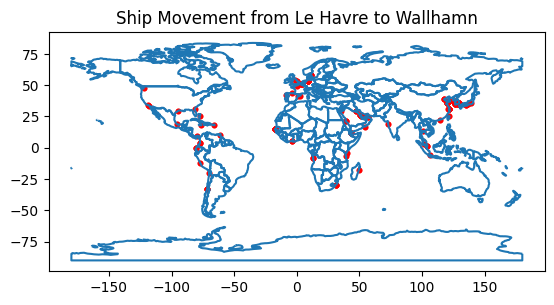

In [237]:
# lines = []
# for i in range(len(morning_champ_df) - 1):
#   start_point = (morning_champ_df.loc[i, 'lon'], morning_champ_df.loc[i, 'lat'])
#   end_point = (morning_champ_df.loc[i + 1, 'lon'], morning_champ_df.loc[i + 1, 'lat'])
#   line = LineString([start_point, end_point])

#   lines.append(line)

# # print(lines)
# gdf_lines = geopandas.GeoDataFrame({'geometry': lines})

# Plotting (adjust world and styles as needed)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.boundary.plot()
# gdf_lines.plot(ax=ax, color='darkblue', linewidth=2, linestyle='--')  # Line color and width


# Plot ship positions at ports (adjust marker and color)
gdf_morning_champ = geopandas.GeoDataFrame(morning_champ_df, geometry=geopandas.points_from_xy(morning_champ_df.lon, morning_champ_df.lat))
gdf_morning_champ.plot(ax=ax, marker='o', color='red', markersize=10)  # Marker style, color, and size
# Title and display
plt.title("Ship Movement from " + morning_champ_df.iloc[0]['place.placeName'] + 
          " to " + morning_champ_df.iloc[-1]['place.placeName'])
plt.show()